# Imports and dataset download

In [ ]:
import csv
import torch 
import sklearn
import scipy
from scipy import io
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt
from torchvision import datasets
import torch.utils.data as data
from sklearn.metrics import accuracy_score, silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score, adjusted_rand_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from scipy.optimize import linear_sum_assignment as linear_assignment
from typing import Optional
import seaborn as sns

import copy
import random
import time
from math import floor

import os


In [ ]:
cuda = True if torch.cuda.is_available() else False
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)

float_Tensor = torch.FloatTensor
if cuda: float_Tensor = torch.cuda.FloatTensor
	
drop_last = True
shuffle = False
IMG_SIZE = 28

In [ ]:
def get_10x_73k(batch_size=64, data_points=-1):
    # Original Labels are within 0 to 9.
    # But proper label mapping is required as there are 8 classes.
    map_labels = {0: 0, 1: 1, 2: 2, 4: 3, 6: 4, 7: 5, 8: 6, 9: 7}
    notebook_path = os.path.abspath("10x_73k-clustering.ipynb")
    labels_path = os.path.join(os.path.dirname(notebook_path), "drive/MyDrive/Diploma/labels.txt")
    data_path = os.path.join(os.path.dirname(notebook_path),"drive/MyDrive/Diploma/sub_set-720.mtx")

    # Read data
    data = scipy.io.mmread(data_path)
    data = data.toarray()
    data = np.log2(data + 1)
    scale = np.max(data)
    data = data / scale
    total_size = data.shape[0]
    random_permutation = np.random.permutation(np.arange(total_size))
    data = data[random_permutation]
    data = np.float32(data)

    # Read labels
    labels = np.loadtxt(labels_path).astype(int)
    labels = labels[random_permutation]
    labels = np.array([map_labels[i] for i in labels])

    if (data_points > 0):
        data = data[:data_points]
        labels = labels[:data_points]

    # Convert to tensor dataset
    tensor_data = torch.Tensor(data)
    data_shape = data.shape[1]
    tensor_labels = torch.Tensor(labels)
    final_dataset = TensorDataset(tensor_data, tensor_labels)
    dataloader = DataLoader(final_dataset, batch_size=batch_size, drop_last=drop_last, shuffle=shuffle)

    return dataloader, data_shape, data, labels

In [ ]:
dataloader, data_shape, datapoints, labels = get_10x_73k(batch_size=128, data_points=10000)

# Autoencoder/Custom dataset/function declarations

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, datapoints, labels, transform=None):

    self.datapoints = datapoints
    self.labels = labels
    self.transform = transform

  def __getitem__(self, index):
    sample = self.datapoints[index], self.labels[index]

    if self.transform:
      sample = self.transform(sample)

    return sample
  
  def __len__(self):
    return len(self.datapoints)

In [ ]:
# TODO: search hungarian algorithm
def cluster_accuracy(y_true, y_predicted, cluster_number: Optional[int] = None):
	"""
	Calculate clustering accuracy after using the linear_sum_assignment function in SciPy to
	determine reassignments.

	:param y_true: list of true cluster numbers, an integer array 0-indexed
	:param y_predicted: list of predicted cluster numbers, an integer array 0-indexed
	:param cluster_number: number of clusters, if None then calculated from input
	:return: reassignment dictionary, clustering accuracy
	"""
	if cluster_number is None:
		# assume labels are 0-indexed
		cluster_number = (max(y_predicted.max(), y_true.max()) + 1)
	count_matrix = np.zeros((cluster_number, cluster_number), dtype=np.int64)
	for i in range(y_predicted.size):
		count_matrix[y_predicted[i], y_true[i]] += 1

	row_ind, col_ind = linear_assignment(count_matrix.max() - count_matrix)
	reassignment = dict(zip(row_ind, col_ind))
	accuracy = count_matrix[row_ind, col_ind].sum() / y_predicted.size
	return reassignment, accuracy

def transform_clusters_to_labels(clusters, labels):
	# Find the cluster ids (labels)
	c_ids = np.unique(clusters)

	# Dictionary to transform cluster label to real label
	dict_clusters_to_labels = dict()

	# For every cluster find the most frequent data label
	for c_id in c_ids:
		indexes_of_cluster_i = np.where(c_id == clusters)
		elements, frequency = np.unique(labels[indexes_of_cluster_i], return_counts=True)
		true_label_index = np.argmax(frequency)
		true_label = elements[true_label_index]
		dict_clusters_to_labels[c_id] = true_label

	# Change the cluster labels to real labels
	for i, element in enumerate(clusters):
		clusters[i] = dict_clusters_to_labels[element]

	return clusters



In [ ]:
def check_number_of_representatives(Y): # TODO: check for empty clusters
  cluster_map = {}

  for element in Y:
    if element not in cluster_map:
      cluster_map[element] = 1
    else:
      cluster_map[element] += 1

  for cluster_number in cluster_map.keys():
    print("Cluster", cluster_number, ":", cluster_map[cluster_number], "elements \n")

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_dimension, hl1_neurons, hl2_neurons, latent_dimension):
        super().__init__()

        # Encoder Model
        self.input_dimension = input_dimension
        self.hl1_neurons = hl1_neurons
        self.hl2_neurons = hl2_neurons
        self.latent_dimension = latent_dimension

        self.encoder_model = nn.Sequential(
          nn.Linear(input_dimension, self.hl1_neurons),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, self.hl2_neurons),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
        )
        
        # Latent Space
        self.latent_space = nn.Sequential(
          nn.Linear(self.hl2_neurons, self.latent_dimension),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.latent_dimension),
        )

        # Decoder Model
        self.decoder_model = nn.Sequential(
          nn.Linear(self.latent_dimension, self.hl2_neurons),
          # nn.ReLU(inplace=True),
          nn.Sigmoid(),
          nn.BatchNorm1d(self.hl2_neurons),
          nn.Linear(self.hl2_neurons, self.hl1_neurons),
          nn.BatchNorm1d(self.hl1_neurons),
          nn.Linear(self.hl1_neurons, input_dimension),
          # nn.ReLU(inplace=True),
          nn.Sigmoid()
        )

    def forward(self, x):
      x = self.encoder_model(x)
      x = self.latent_space(x)
      x = self.decoder_model(x)
      return x
  
    def encoder(self, x, device):
      x = torch.from_numpy(x).to(device)
      x = self.encoder_model(x)
      x = self.latent_space(x)
      return x.cpu().detach().numpy()

In [ ]:
def train_autoencoder(device, dataloader, autoencoder, epochs=500):
	criterion = nn.MSELoss().to(device)
	optimizer = optim.Adam(autoencoder.parameters(), lr=1e-4, weight_decay=1e-5)
	loss_list = list()
	batch_size = 128
	
	autoencoder.train()
	for epoch in range(epochs):
		loss = 0
		for batch_index, (batch, labels) in enumerate(dataloader):
			# Data to the GPU (cuda)
			batch = Variable(batch.type(float_Tensor))
			
			# Indexes
			low_index = batch_index * batch_size
			high_index = (batch_index + 1) * batch_size
			
			# reset the gradients to zero
			optimizer.zero_grad()
			autoencoder.zero_grad()

			# compute reconstructions
			reconstructions = autoencoder(batch)

			# compute training reconstruction loss
			train_loss = criterion(reconstructions, batch)

			# compute accumulated gradients
			train_loss.backward()

			# perform parameter update based on current gradients
			optimizer.step()

			# add the mini-batch training loss to epoch loss
			loss += train_loss.item()

		loss = loss / len(dataloader)
		loss_list.append(loss)
		print("Epoch: {}/{}, Loss: {:.6f}".format(epoch + 1, epochs, loss))
		
	autoencoder.eval()
	return autoencoder, loss_list

# Clustering

In [ ]:
kmeans_8_clusters = KMeans(n_clusters=8, n_init=100).fit(datapoints)
retrieved_labels_8_clusters = transform_clusters_to_labels(kmeans_8_clusters.labels_, labels)

print("K_means greedy accuracy score for 8 clusters on initial space:",accuracy_score(labels, retrieved_labels_8_clusters))
print("K_means hungarian accuracy score for 8 clusters on initial space:",cluster_accuracy(labels, kmeans_8_clusters.labels_)[1])
print("K-means normalised mutual info score for 8 clusters on initial space:",normalized_mutual_info_score(labels, kmeans_8_clusters.labels_))
print("K-means ARI for 8 clusters on initial space:",adjusted_rand_score(labels, kmeans_8_clusters.labels_))
print("K-means silhouette score for 2 clusters on initial space:",silhouette_score(datapoints, kmeans_8_clusters.labels_))

K_means greedy accuracy score for 8 clusters on initial space: 0.5965
K_means hungarian accuracy score for 8 clusters on initial space: 0.5965
K-means normalised mutual info score for 8 clusters on initial space: 0.5518151574030541
K-means ARI for 8 clusters on initial space: 0.3743634616151183
K-means silhouette score for 2 clusters on initial space: 0.054958556


In [ ]:
aggloClustering_8_clusters = AgglomerativeClustering(n_clusters=8).fit(datapoints)
agglo_retrieved_labels = transform_clusters_to_labels(aggloClustering_8_clusters.labels_, labels)

# print the stats on agglomerative clustering

print("Agglomerative clustering on initial space greedy accuracy score:",accuracy_score(labels, agglo_retrieved_labels))
print("Agglomerative clustering on initial space hungarian accuracy score:",cluster_accuracy(labels, aggloClustering_8_clusters.labels_)[1])
print("Normalised mutual info score on agglomerative clustering on initial space:",normalized_mutual_info_score(labels, aggloClustering_8_clusters.labels_))
print("Agglomerative clustering ARI on initial space:",adjusted_rand_score(labels, aggloClustering_8_clusters.labels_))
print("Agglomerative clustering silhouette score for 2 clusters on initial space:",silhouette_score(datapoints, aggloClustering_8_clusters.labels_))

Agglomerative clustering on initial space greedy accuracy score: 0.6324
Agglomerative clustering on initial space hungarian accuracy score: 0.6324
Normalised mutual info score on agglomerative clustering on initial space: 0.6098092634047008
Agglomerative clustering ARI on initial space: 0.49823171790729137
Agglomerative clustering silhouette score for 2 clusters on initial space: 0.042042352


In [ ]:
data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(datapoints)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.009s...
[t-SNE] Computed neighbors for 10000 samples in 4.587s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.346282
[t-SNE] KL divergence after 250 iterations with early exaggeration: 87.656876
[t-SNE] KL divergence after 400 iterations: 3.136791


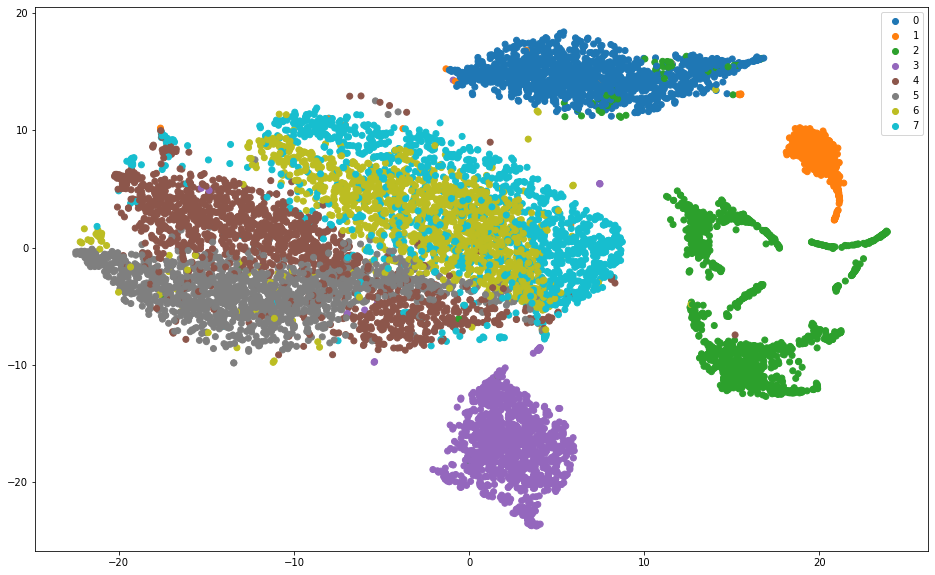

In [ ]:
dataset_labels = [0,1,2,3,4,5,6,7,8,9]

plt.figure(figsize=(16,10))
scatterplot = plt.scatter(
    x=data_TSNE[:,0], y=data_TSNE[:,1],
    c=labels,
    cmap="tab10"
)

handles, _ = scatterplot.legend_elements(prop='colors')
plt.legend(handles, dataset_labels)

In [ ]:
def run_experiment(K, dataloader, data_shape, datapoints, labels, epochs=30, hl1_neurons=700, hl2_neurons=200, latent_dimension=10):

  print('Experiment results for k-means with k =', K, 'clusters:\n')
  print('Running k-means algorithm in order to get our pseudolabels: \n')

  kmeans_initial = KMeans(n_clusters=K, n_init=100).fit(datapoints) 
  cluster_centers = kmeans_initial.cluster_centers_
  cluster_labels = kmeans_initial.labels_
  real_labels = transform_clusters_to_labels(cluster_labels, labels)

  # check TSNE representation of our features according to the k categories

  # print("Creating TSNE representation of our features according to the k categories...\n")

  # pseudolabels_indices = [i for i in range(K)]

  # plt.figure(figsize=(16,10)) 
  # kmeans_scatterplot = plt.scatter(
  #     x=data_TSNE[:,0], y=data_TSNE[:,1],
  #     c=cluster_labels,
  #     cmap="gist_rainbow"
  # )

  # handles = kmeans_scatterplot.legend_elements(num=pseudolabels_indices)[0]
  # plt.legend(handles, pseudolabels_indices)

  # savestring = 'pseudolabels_TSNE_initial_space_k=' + str(K) + '.png'
  # plt.savefig(savestring)

  # find out accuracy of the algorithm in the initial space

  kmeans_initial_hungarian_acc = cluster_accuracy(labels, cluster_labels)[1]
  kmeans_initial_NMI = normalized_mutual_info_score(labels, cluster_labels)
  kmeans_initial_ARI = adjusted_rand_score(labels, cluster_labels)

  print("K_means greedy accuracy score (initial space):",accuracy_score(labels, real_labels))
  print("K_means hungarian accuracy score (initial space):",kmeans_initial_hungarian_acc)
  print("Normalised mutual info score (initial space):",kmeans_initial_NMI)
  print("ARI (initial space):",kmeans_initial_ARI, "\n")

  # using the autoencoder model on our data

  print('Using the autoencoder model on our data: \n')

  kmeans_accuracy_scores = []
  k_means_silhouette_scores = []
  k_means_cluster_error_scores = []
  kmeans_NMI_scores = []
  kmeans_ARI_scores = []
  agglo_accuracy_scores = []
  agglo_NMI_scores = []
  agglo_ARI_scores = []
  agglo_silhouette_scores = []
  
  for i in range(10):

    print("ROUND NUMBER ",i + 1,":\n")
    autoencoder = Autoencoder(input_dimension=data_shape, hl1_neurons=hl1_neurons, hl2_neurons=hl2_neurons, latent_dimension=latent_dimension).to(device)
    autoencoder, loss_list = train_autoencoder(device, dataloader, autoencoder, epochs=epochs)
    latent_data = autoencoder.encoder(datapoints, device)

    # data_TSNE = TSNE(n_components=2, verbose=1, perplexity=20, n_iter=400, learning_rate='auto').fit_transform(latent_data)

    # dataset_labels = [0,1,2,3,4,5,6,7,8,9]

    # plt.figure(figsize=(16,10))
    # scatterplot = plt.scatter(
    #     x=data_TSNE[:,0], y=data_TSNE[:,1],
    #     c=labels,
    #     cmap="tab10"
    # )

    # handles, _ = scatterplot.legend_elements(prop='colors')
    # plt.legend(handles, dataset_labels)
    
    print("Creating a k-means model on latent data:\n")

    # Maybe we need Standar Scaler

    # std_scaler = StandardScaler()
    # latent_data = std_scaler.fit_transform(latent_data)

    # Clustering on transformed space

    new_kmeans = KMeans(n_clusters=8, n_init=100).fit(latent_data)

    kmeans_clusters = new_kmeans.labels_
    kmeans_cluster_error = new_kmeans.inertia_
    k_means_cluster_error_scores.append(kmeans_cluster_error)
    kmeans_greedy_labels = transform_clusters_to_labels(kmeans_clusters, labels)

    # print the stats on the transformed space
    kmeans_greedy_acc = accuracy_score(labels, kmeans_greedy_labels)

    # These metrics as input they use the output of the clustering algorithm
    kmeans_hungarian_acc = cluster_accuracy(labels, kmeans_clusters)[1]
    kmeans_NMI = normalized_mutual_info_score(labels, kmeans_clusters)
    kmeans_ARI = adjusted_rand_score(labels, kmeans_clusters)

    kmeans_accuracy_scores.append(kmeans_hungarian_acc)
    kmeans_NMI_scores.append(kmeans_NMI)
    kmeans_ARI_scores.append(kmeans_ARI)

    k_means_silhouette_score = silhouette_score(latent_data, kmeans_clusters)
    k_means_silhouette_scores.append(k_means_silhouette_score)

    print("K-means with 8 clusters on latent space stats: \n")
    print("K-means on latent space greedy accuracy score:",kmeans_greedy_acc)
    print("K-means on latent space hungarian accuracy score:",kmeans_hungarian_acc)
    print("Normalised mutual info score on k-means on latent space:", kmeans_NMI)
    print("ARI score on k-means on latent space:", kmeans_ARI)
    print("K-means cluster error on latent space:", kmeans_cluster_error)
    print("K-means silhouette score on latent space:", k_means_silhouette_score, "\n")

    # do agglomerative clustering on the transformed space

    print("Doing agglomerative clustering on MLP output vectors:\n")
    aggloClustering = AgglomerativeClustering(n_clusters=8).fit(latent_data)
    aggloClustering_clusters = aggloClustering.labels_
    agglo_greedy_labels = transform_clusters_to_labels(aggloClustering_clusters, labels)

    # print the stats on agglomerative clustering
    agglo_greedy_acc = accuracy_score(labels, agglo_greedy_labels)
    agglo_hungarian_acc = cluster_accuracy(labels, aggloClustering_clusters)[1]
    agglo_NMI = normalized_mutual_info_score(labels, aggloClustering_clusters)
    agglo_ARI = adjusted_rand_score(labels, aggloClustering_clusters)
    agglo_silhouette = k_means_silhouette_score = silhouette_score(latent_data, aggloClustering_clusters)

    agglo_accuracy_scores.append(agglo_greedy_acc)
    agglo_NMI_scores.append(agglo_NMI)
    agglo_ARI_scores.append(agglo_ARI)
    agglo_silhouette_scores.append(agglo_silhouette)

    print("Agglomerative clustering on latent space greedy accuracy score:", agglo_greedy_acc)
    print("Agglomerative clustering on latent space hungarian accuracy score:", agglo_hungarian_acc)
    print("Normalised mutual info score on agglomerative clustering on latent space:",agglo_NMI, "\n")
    print("ARI score on agglomerative clustering on latent space:", agglo_ARI, "\n")

  print("Average k-means accuracy score at latent space:", sum(kmeans_accuracy_scores) / len(kmeans_accuracy_scores), "\n")
  print("Average k-means NMI score at latent space:", sum(kmeans_NMI_scores) / len(kmeans_NMI_scores), "\n")
  print("Average k-means ARI score at latent space:", sum(kmeans_ARI_scores) / len(kmeans_ARI_scores), "\n")
  print("Average agglomerative clustering accuracy score at latent space:", sum(agglo_accuracy_scores) / len(agglo_accuracy_scores), "\n")
  print("Average agglomerative clustering NMI score at latent space:", sum(agglo_NMI_scores) / len(agglo_NMI_scores), "\n")
  print("Average agglomerative clustering ARI score at latent space:", sum(agglo_ARI_scores) / len(agglo_ARI_scores), "\n")
  print("Average k-means silhouette score on latent space:", sum(k_means_silhouette_scores) / len(k_means_silhouette_scores), "\n")
  print("Average k-means cluster error on latent space:", sum(k_means_cluster_error_scores) / len(k_means_cluster_error_scores), "\n")

  return [ kmeans_accuracy_scores, kmeans_NMI_scores, kmeans_ARI_scores, agglo_accuracy_scores, agglo_NMI_scores, agglo_ARI_scores, k_means_silhouette_scores, agglo_silhouette_scores]

In [ ]:
res = run_experiment(55, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.9076
K_means hungarian accuracy score (initial space): 0.9076
Normalised mutual info score (initial space): 0.8459116872681266
ARI (initial space): 0.8092864885751136 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.179073
Epoch: 2/50, Loss: 0.158052
Epoch: 3/50, Loss: 0.127289
Epoch: 4/50, Loss: 0.093072
Epoch: 5/50, Loss: 0.060817
Epoch: 6/50, Loss: 0.039966
Epoch: 7/50, Loss: 0.029056
Epoch: 8/50, Loss: 0.023673
Epoch: 9/50, Loss: 0.020923
Epoch: 10/50, Loss: 0.019388
Epoch: 11/50, Loss: 0.018453
Epoch: 12/50, Loss: 0.017088
Epoch: 13/50, Loss: 0.016420
Epoch: 14/50, Loss: 0.015685
Epoch: 15/50, Loss: 0.015402
Epoch: 16/50, Loss: 0.014909
Epoch: 17/50, Loss: 0.014757
Epoch: 18/50, Loss: 0.014858
Epoch: 19/50, Loss: 0.014198
Epoch: 20/50, Loss: 0.013814
Epoch: 21/50, Loss: 0.013692
Epoc

In [ ]:
print(np.std(res[7]))
print(np.mean(res[7]))

0.013848441
0.34321347


In [ ]:
results_for_k_15 = run_experiment(15, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 15 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.6815
K_means hungarian accuracy score (initial space): 0.6815
Normalised mutual info score (initial space): 0.5974519134462243
ARI (initial space): 0.47147927603743556 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178648
Epoch: 2/50, Loss: 0.159197
Epoch: 3/50, Loss: 0.129058
Epoch: 4/50, Loss: 0.092079
Epoch: 5/50, Loss: 0.057905
Epoch: 6/50, Loss: 0.036900
Epoch: 7/50, Loss: 0.026742
Epoch: 8/50, Loss: 0.021781
Epoch: 9/50, Loss: 0.019230
Epoch: 10/50, Loss: 0.017823
Epoch: 11/50, Loss: 0.016831
Epoch: 12/50, Loss: 0.016257
Epoch: 13/50, Loss: 0.015602
Epoch: 14/50, Loss: 0.015132
Epoch: 15/50, Loss: 0.014937
Epoch: 16/50, Loss: 0.014611
Epoch: 17/50, Loss: 0.014161
Epoch: 18/50, Loss: 0.014120
Epoch: 19/50, Loss: 0.013895
Epoch: 20/50, Loss: 0.013639
Epoch: 21/50, Loss: 0.013621
Epo

In [ ]:
results_for_k_20 = run_experiment(20, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 20 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.7718
K_means hungarian accuracy score (initial space): 0.7718
Normalised mutual info score (initial space): 0.6919931472861534
ARI (initial space): 0.5987591693751205 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178522
Epoch: 2/50, Loss: 0.159531
Epoch: 3/50, Loss: 0.128553
Epoch: 4/50, Loss: 0.091616
Epoch: 5/50, Loss: 0.057626
Epoch: 6/50, Loss: 0.036996
Epoch: 7/50, Loss: 0.026954
Epoch: 8/50, Loss: 0.022016
Epoch: 9/50, Loss: 0.019333
Epoch: 10/50, Loss: 0.017962
Epoch: 11/50, Loss: 0.016947
Epoch: 12/50, Loss: 0.016345
Epoch: 13/50, Loss: 0.015813
Epoch: 14/50, Loss: 0.015342
Epoch: 15/50, Loss: 0.015146
Epoch: 16/50, Loss: 0.014996
Epoch: 17/50, Loss: 0.014735
Epoch: 18/50, Loss: 0.014449
Epoch: 19/50, Loss: 0.014250
Epoch: 20/50, Loss: 0.014093
Epoch: 21/50, Loss: 0.013969
Epoc

In [ ]:
results_for_k_25 = run_experiment(25, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 25 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8354
K_means hungarian accuracy score (initial space): 0.8354
Normalised mutual info score (initial space): 0.7431112050560154
ARI (initial space): 0.6738920139543506 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178426
Epoch: 2/50, Loss: 0.158000
Epoch: 3/50, Loss: 0.126742
Epoch: 4/50, Loss: 0.091499
Epoch: 5/50, Loss: 0.059078
Epoch: 6/50, Loss: 0.038845
Epoch: 7/50, Loss: 0.028625
Epoch: 8/50, Loss: 0.023437
Epoch: 9/50, Loss: 0.020768
Epoch: 10/50, Loss: 0.018998
Epoch: 11/50, Loss: 0.018014
Epoch: 12/50, Loss: 0.017356
Epoch: 13/50, Loss: 0.016847
Epoch: 14/50, Loss: 0.016554
Epoch: 15/50, Loss: 0.015990
Epoch: 16/50, Loss: 0.015596
Epoch: 17/50, Loss: 0.015251
Epoch: 18/50, Loss: 0.015006
Epoch: 19/50, Loss: 0.015025
Epoch: 20/50, Loss: 0.014411
Epoch: 21/50, Loss: 0.014691
Epoc

In [ ]:
results_for_k_30 = run_experiment(30, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 30 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8377
K_means hungarian accuracy score (initial space): 0.8377
Normalised mutual info score (initial space): 0.7720974385888981
ARI (initial space): 0.6922988035806561 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178741
Epoch: 2/50, Loss: 0.160598
Epoch: 3/50, Loss: 0.128168
Epoch: 4/50, Loss: 0.091715
Epoch: 5/50, Loss: 0.058520
Epoch: 6/50, Loss: 0.038385
Epoch: 7/50, Loss: 0.027977
Epoch: 8/50, Loss: 0.023036
Epoch: 9/50, Loss: 0.020392
Epoch: 10/50, Loss: 0.018673
Epoch: 11/50, Loss: 0.017602
Epoch: 12/50, Loss: 0.016910
Epoch: 13/50, Loss: 0.016307
Epoch: 14/50, Loss: 0.015773
Epoch: 15/50, Loss: 0.015559
Epoch: 16/50, Loss: 0.014992
Epoch: 17/50, Loss: 0.014793
Epoch: 18/50, Loss: 0.014590
Epoch: 19/50, Loss: 0.014553
Epoch: 20/50, Loss: 0.014464
Epoch: 21/50, Loss: 0.014346
Epoc

In [ ]:
results_for_k_35 = run_experiment(35, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 35 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8496
K_means hungarian accuracy score (initial space): 0.8496
Normalised mutual info score (initial space): 0.7663491405662949
ARI (initial space): 0.7060689590722276 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178725
Epoch: 2/50, Loss: 0.161113
Epoch: 3/50, Loss: 0.127325
Epoch: 4/50, Loss: 0.091643
Epoch: 5/50, Loss: 0.058516
Epoch: 6/50, Loss: 0.037896
Epoch: 7/50, Loss: 0.027608
Epoch: 8/50, Loss: 0.022748
Epoch: 9/50, Loss: 0.020073
Epoch: 10/50, Loss: 0.018399
Epoch: 11/50, Loss: 0.017554
Epoch: 12/50, Loss: 0.016894
Epoch: 13/50, Loss: 0.016723
Epoch: 14/50, Loss: 0.016262
Epoch: 15/50, Loss: 0.015952
Epoch: 16/50, Loss: 0.015573
Epoch: 17/50, Loss: 0.015196
Epoch: 18/50, Loss: 0.014934
Epoch: 19/50, Loss: 0.014668
Epoch: 20/50, Loss: 0.013909
Epoch: 21/50, Loss: 0.014686
Epoc

In [ ]:
results_for_k_40 = run_experiment(40, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 40 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8638
K_means hungarian accuracy score (initial space): 0.8638
Normalised mutual info score (initial space): 0.7912534470766547
ARI (initial space): 0.7363286917060886 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178831
Epoch: 2/50, Loss: 0.160189
Epoch: 3/50, Loss: 0.128359
Epoch: 4/50, Loss: 0.091699
Epoch: 5/50, Loss: 0.058283
Epoch: 6/50, Loss: 0.037875
Epoch: 7/50, Loss: 0.027799
Epoch: 8/50, Loss: 0.022601
Epoch: 9/50, Loss: 0.019919
Epoch: 10/50, Loss: 0.018216
Epoch: 11/50, Loss: 0.017210
Epoch: 12/50, Loss: 0.016505
Epoch: 13/50, Loss: 0.015996
Epoch: 14/50, Loss: 0.015685
Epoch: 15/50, Loss: 0.015473
Epoch: 16/50, Loss: 0.015351
Epoch: 17/50, Loss: 0.014986
Epoch: 18/50, Loss: 0.014677
Epoch: 19/50, Loss: 0.014300
Epoch: 20/50, Loss: 0.013989
Epoch: 21/50, Loss: 0.013928
Epoc

In [ ]:
results_for_k_45 = run_experiment(45, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 45 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8576
K_means hungarian accuracy score (initial space): 0.8576
Normalised mutual info score (initial space): 0.7895175440617161
ARI (initial space): 0.7240218026354653 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178677
Epoch: 2/50, Loss: 0.161135
Epoch: 3/50, Loss: 0.129621
Epoch: 4/50, Loss: 0.091652
Epoch: 5/50, Loss: 0.057268
Epoch: 6/50, Loss: 0.036488
Epoch: 7/50, Loss: 0.026478
Epoch: 8/50, Loss: 0.021397
Epoch: 9/50, Loss: 0.018766
Epoch: 10/50, Loss: 0.017430
Epoch: 11/50, Loss: 0.016470
Epoch: 12/50, Loss: 0.015767
Epoch: 13/50, Loss: 0.015271
Epoch: 14/50, Loss: 0.015075
Epoch: 15/50, Loss: 0.014679
Epoch: 16/50, Loss: 0.014557
Epoch: 17/50, Loss: 0.014099
Epoch: 18/50, Loss: 0.014095
Epoch: 19/50, Loss: 0.013185
Epoch: 20/50, Loss: 0.012434
Epoch: 21/50, Loss: 0.012190
Epoc

In [ ]:
results_for_k_50 = run_experiment(50, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 50 clusters:

Running k-means algorithm in order to get our pseudolabels: 



In [ ]:
results_for_k_55 = run_experiment(55, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 55 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.887
K_means hungarian accuracy score (initial space): 0.887
Normalised mutual info score (initial space): 0.8150806549814895
ARI (initial space): 0.7701289126838237 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178455
Epoch: 2/50, Loss: 0.158068
Epoch: 3/50, Loss: 0.127055
Epoch: 4/50, Loss: 0.092117
Epoch: 5/50, Loss: 0.058673
Epoch: 6/50, Loss: 0.038179
Epoch: 7/50, Loss: 0.028150
Epoch: 8/50, Loss: 0.022946
Epoch: 9/50, Loss: 0.020168
Epoch: 10/50, Loss: 0.018757
Epoch: 11/50, Loss: 0.017960
Epoch: 12/50, Loss: 0.017084
Epoch: 13/50, Loss: 0.016623
Epoch: 14/50, Loss: 0.016159
Epoch: 15/50, Loss: 0.015832
Epoch: 16/50, Loss: 0.015642
Epoch: 17/50, Loss: 0.015534
Epoch: 18/50, Loss: 0.015434
Epoch: 19/50, Loss: 0.015113
Epoch: 20/50, Loss: 0.014619
Epoch: 21/50, Loss: 0.014793
Epoch:

In [ ]:
results_for_k_60 = run_experiment(60, dataloader, data_shape, datapoints, labels, epochs=50, hl1_neurons=800, hl2_neurons=300, latent_dimension=8)

Experiment results for k-means with k = 60 clusters:

Running k-means algorithm in order to get our pseudolabels: 

K_means greedy accuracy score (initial space): 0.8908
K_means hungarian accuracy score (initial space): 0.8908
Normalised mutual info score (initial space): 0.8186783775392639
ARI (initial space): 0.7754688470536985 

Using the autoencoder model on our data: 

ROUND NUMBER  1 :

Epoch: 1/50, Loss: 0.178894
Epoch: 2/50, Loss: 0.159177
Epoch: 3/50, Loss: 0.127873
Epoch: 4/50, Loss: 0.091489
Epoch: 5/50, Loss: 0.057760
Epoch: 6/50, Loss: 0.037115
Epoch: 7/50, Loss: 0.027106
Epoch: 8/50, Loss: 0.022346
Epoch: 9/50, Loss: 0.019916
Epoch: 10/50, Loss: 0.018364
Epoch: 11/50, Loss: 0.017556
Epoch: 12/50, Loss: 0.016837
Epoch: 13/50, Loss: 0.016208
Epoch: 14/50, Loss: 0.015849
Epoch: 15/50, Loss: 0.015583
Epoch: 16/50, Loss: 0.015428
Epoch: 17/50, Loss: 0.015098
Epoch: 18/50, Loss: 0.015018
Epoch: 19/50, Loss: 0.014771
Epoch: 20/50, Loss: 0.014486
Epoch: 21/50, Loss: 0.014196
Epoc

In [ ]:
kmeans_acc = np.zeros((5,10))
kmeans_NMI = np.zeros((5,10))
kmeans_ARI = np.zeros((5,10))
agglo_acc = np.zeros((5,10))
agglo_NMI = np.zeros((5,10))
agglo_ARI = np.zeros((5,10))
kmeans_silhouette = np.zeros((5,10))

for i in range(5):
  
  kmeans_acc[i][0] = results_for_k_15[0][i]
  kmeans_acc[i][1] = results_for_k_20[0][i]
  kmeans_acc[i][2] = results_for_k_25[0][i]
  kmeans_acc[i][3] = results_for_k_30[0][i]
  kmeans_acc[i][4] = results_for_k_35[0][i]
  kmeans_acc[i][5] = results_for_k_40[0][i]
  kmeans_acc[i][6] = results_for_k_45[0][i]
  kmeans_acc[i][7] = results_for_k_50[0][i]
  kmeans_acc[i][8] = results_for_k_55[0][i]
  kmeans_acc[i][9] = results_for_k_60[0][i]

  kmeans_NMI[i][0] = results_for_k_15[1][i]
  kmeans_NMI[i][1] = results_for_k_20[1][i]
  kmeans_NMI[i][2] = results_for_k_25[1][i]
  kmeans_NMI[i][3] = results_for_k_30[1][i]
  kmeans_NMI[i][4] = results_for_k_35[1][i]
  kmeans_NMI[i][5] = results_for_k_40[1][i]
  kmeans_NMI[i][6] = results_for_k_45[1][i]
  kmeans_NMI[i][7] = results_for_k_50[1][i]
  kmeans_NMI[i][8] = results_for_k_55[1][i]
  kmeans_NMI[i][9] = results_for_k_60[1][i]

  kmeans_ARI[i][0] = results_for_k_15[2][i]
  kmeans_ARI[i][1] = results_for_k_20[2][i]
  kmeans_ARI[i][2] = results_for_k_25[2][i]
  kmeans_ARI[i][3] = results_for_k_30[2][i]
  kmeans_ARI[i][4] = results_for_k_35[2][i]
  kmeans_ARI[i][5] = results_for_k_40[2][i]
  kmeans_ARI[i][6] = results_for_k_45[2][i]
  kmeans_ARI[i][7] = results_for_k_50[2][i]
  kmeans_ARI[i][8] = results_for_k_55[2][i]
  kmeans_ARI[i][9] = results_for_k_60[2][i]

  agglo_acc[i][0] = results_for_k_15[3][i]
  agglo_acc[i][1] = results_for_k_20[3][i]
  agglo_acc[i][2] = results_for_k_25[3][i]
  agglo_acc[i][3] = results_for_k_30[3][i]
  agglo_acc[i][4] = results_for_k_35[3][i]
  agglo_acc[i][5] = results_for_k_40[3][i]
  agglo_acc[i][6] = results_for_k_45[3][i]
  agglo_acc[i][7] = results_for_k_50[3][i]
  agglo_acc[i][8] = results_for_k_55[3][i]
  agglo_acc[i][9] = results_for_k_60[3][i]

  agglo_NMI[i][0] = results_for_k_15[4][i]
  agglo_NMI[i][1] = results_for_k_20[4][i]
  agglo_NMI[i][2] = results_for_k_25[4][i]
  agglo_NMI[i][3] = results_for_k_30[4][i]
  agglo_NMI[i][4] = results_for_k_35[4][i]
  agglo_NMI[i][5] = results_for_k_40[4][i]
  agglo_NMI[i][6] = results_for_k_45[4][i]
  agglo_NMI[i][7] = results_for_k_50[4][i]
  agglo_NMI[i][8] = results_for_k_55[4][i]
  agglo_NMI[i][9] = results_for_k_60[4][i]

  agglo_ARI[i][0] = results_for_k_15[5][i]
  agglo_ARI[i][1] = results_for_k_20[5][i]
  agglo_ARI[i][2] = results_for_k_25[5][i]
  agglo_ARI[i][3] = results_for_k_30[5][i]
  agglo_ARI[i][4] = results_for_k_35[5][i]
  agglo_ARI[i][5] = results_for_k_40[5][i]
  agglo_ARI[i][6] = results_for_k_45[5][i]
  agglo_ARI[i][7] = results_for_k_50[5][i]
  agglo_ARI[i][8] = results_for_k_55[5][i]
  agglo_ARI[i][9] = results_for_k_60[5][i]

  kmeans_silhouette[i][0] = results_for_k_15[6][i]
  kmeans_silhouette[i][1] = results_for_k_20[6][i]
  kmeans_silhouette[i][2] = results_for_k_25[6][i]
  kmeans_silhouette[i][3] = results_for_k_30[6][i]
  kmeans_silhouette[i][4] = results_for_k_35[6][i]
  kmeans_silhouette[i][5] = results_for_k_40[6][i]
  kmeans_silhouette[i][6] = results_for_k_45[6][i]
  kmeans_silhouette[i][7] = results_for_k_50[6][i]
  kmeans_silhouette[i][8] = results_for_k_55[6][i]
  kmeans_silhouette[i][9] = results_for_k_60[6][i]


Text(0.5, 0, 'K')

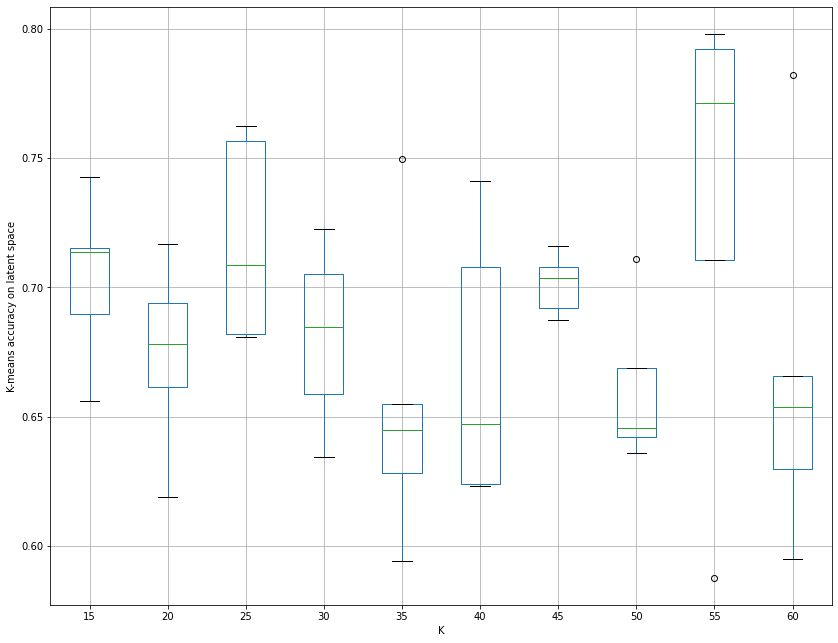

In [ ]:
columns = ['15', '20', '25', '30', '35', '40', '45', '50', '55', '60']

df = pd.DataFrame(kmeans_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

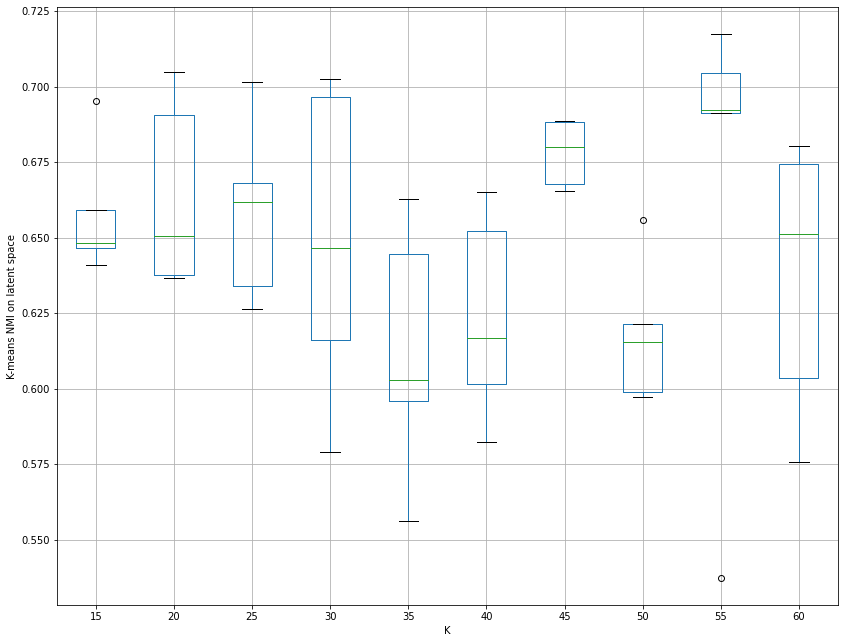

In [ ]:
df = pd.DataFrame(kmeans_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

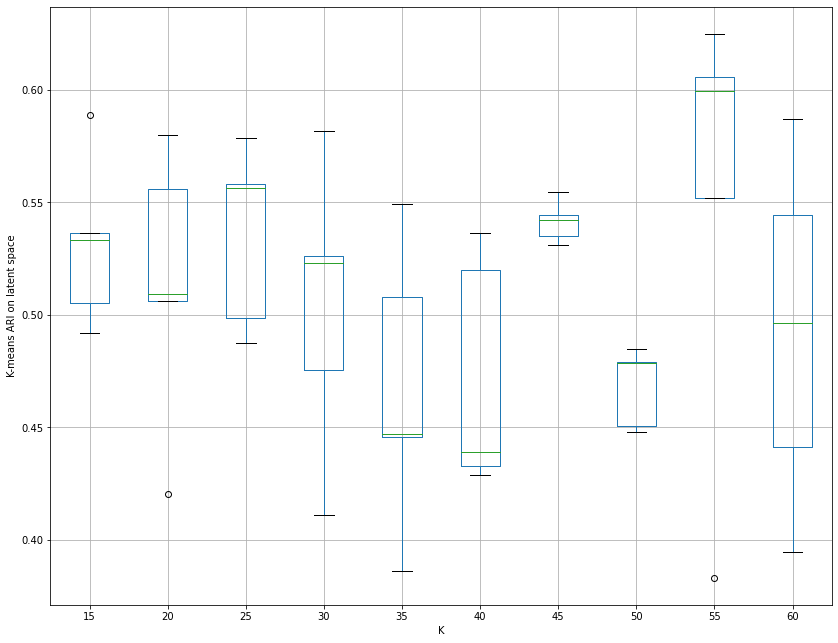

In [ ]:
df = pd.DataFrame(kmeans_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

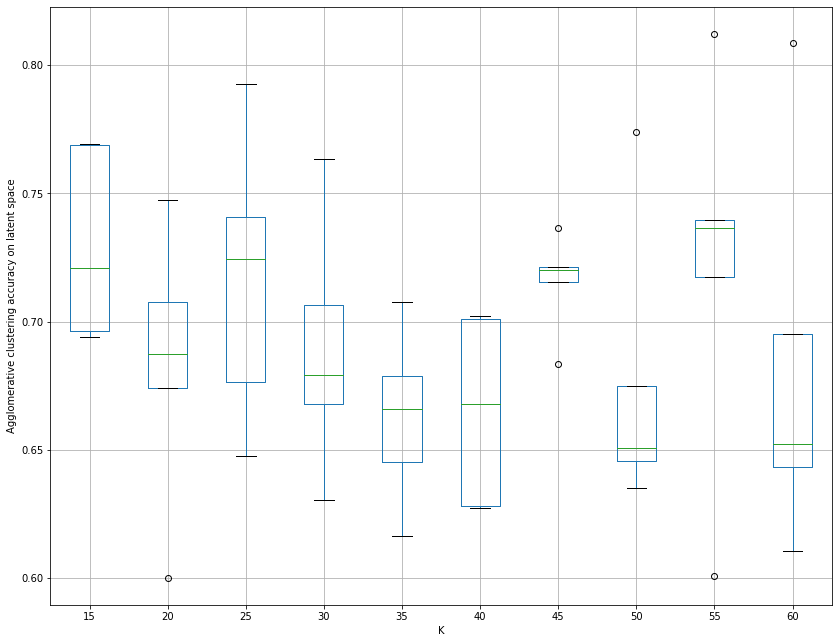

In [ ]:
df = pd.DataFrame(agglo_acc,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering accuracy on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

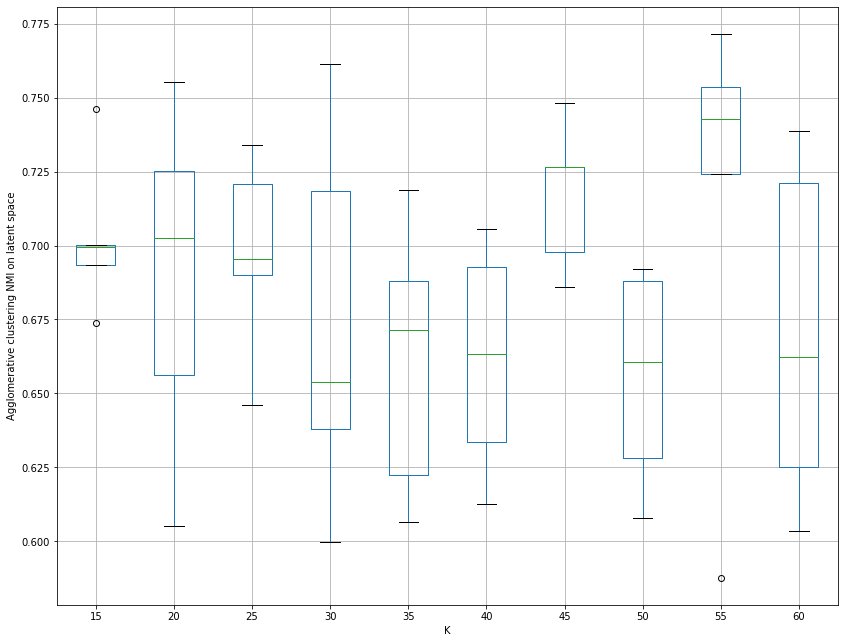

In [ ]:
df = pd.DataFrame(agglo_NMI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering NMI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

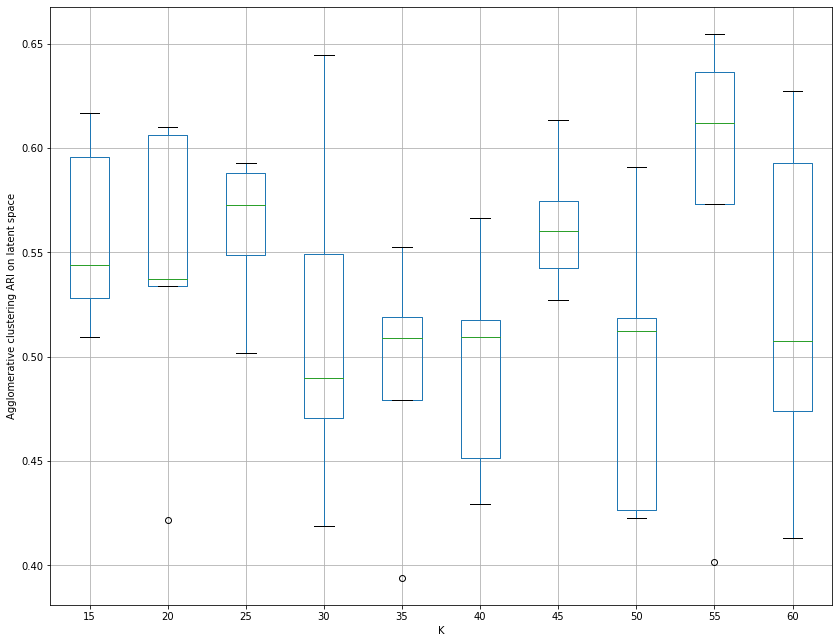

In [ ]:
df = pd.DataFrame(agglo_ARI,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('Agglomerative clustering ARI on latent space')
boxplot.set_xlabel('K')

Text(0.5, 0, 'K')

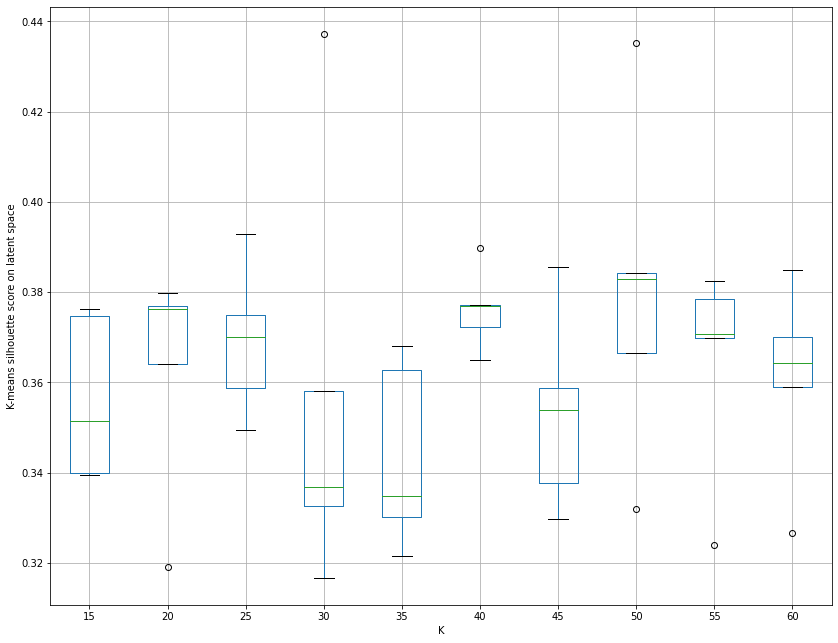

In [ ]:
df = pd.DataFrame(kmeans_silhouette,
                  columns=columns)
boxplot = df.boxplot(column=columns, figsize=(14,11))  
boxplot.set_ylabel('K-means silhouette score on latent space')
boxplot.set_xlabel('K')